# トマト - 検出 - 追跡 

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Data-inspection-(検査)" data-toc-modified-id="Data-inspection-(検査)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data inspection (検査)</a></span></li><li><span><a href="#YOLOV8-all-in-one-tracking-(追跡)" data-toc-modified-id="YOLOV8-all-in-one-tracking-(追跡)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>YOLOV8 all-in-one tracking (追跡)</a></span></li><li><span><a href="#Instance-segementation" data-toc-modified-id="Instance-segementation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Instance segementation</a></span><ul class="toc-item"><li><span><a href="#Inspect-and-understand-the-inference-results" data-toc-modified-id="Inspect-and-understand-the-inference-results-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Inspect and understand the inference results</a></span></li><li><span><a href="#Refining-segmentation-masks-/-Retrieve-tomatoes" data-toc-modified-id="Refining-segmentation-masks-/-Retrieve-tomatoes-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Refining segmentation masks / Retrieve tomatoes</a></span></li></ul></li><li><span><a href="#Tracking" data-toc-modified-id="Tracking-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Tracking</a></span><ul class="toc-item"><li><span><a href="#Centroid-estimation" data-toc-modified-id="Centroid-estimation-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Centroid estimation</a></span></li><li><span><a href="#Nearest-Neighbor-association" data-toc-modified-id="Nearest-Neighbor-association-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Nearest Neighbor association</a></span></li><li><span><a href="#Associate-instances-with-centroids" data-toc-modified-id="Associate-instances-with-centroids-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Associate instances with centroids</a></span></li><li><span><a href="#Plot-the-results" data-toc-modified-id="Plot-the-results-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Plot the results</a></span></li></ul></li></ul></div>

## Introduction
The following moduls (libs) are necessary to run the notebook (uncomment to update and install): 

In [1]:
#!pip install --upgrade numpy torch ultralytics matplotlib moviepy mediapy gdown ### 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 288.7 kB/s eta 0:00:00 0:00:01


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 30.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 MB 8.0 MB/s eta 0:00:0000:01m00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.3/645.3 kB 5.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 8.0 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 3.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 4.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 2.2 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
  Attempting uninstall: torch
    Found existing installation: torch 2.1.0
    Uninstalling torch-2.1.0:
      Successfully uninstalled torch-2.1.0
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.8.0


このノートブックでは、yoloV8 を使用して個々のトマトを検出および追跡する簡単な手順を説明します。 インスタンスの分割には、「YOLOv8x-seg」に基づく事前トレーニング済みモデルが使用されます。 モデルは少数の画像のみでトレーニングされています。 ただし、トレーニングおよび検証のデータセットは、幾何学的拡張によって拡張されています。


ノートブックを実行するには次のモジュールが必要です。

Yolo V8 について：
https://github.com/ultralytics/ultralytics

Instance segementation について：

- https://docs.ultralytics.com/tasks/segment/

Object tracking:

- https://docs.ultralytics.com/modes/track/#why-choose-ultralytics-yolo-for-object-tracking
 - Bot-SORT: https://github.com/NirAharon/BoT-SORT
 - ByteTrack: https://github.com/ifzhang/ByteTrack
 
model training について：

- https://docs.ultralytics.com/modes/train/#why-choose-ultralytics-yolo-for-training

following we will import all necessary libs:

In [2]:
%reload_ext autoreload
%autoreload 2

from tqdm import tqdm
from glob import glob

#### image - array operations
import numpy as np

from scipy import spatial

import cv2
from skimage import measure, transform

#### DNN - detection
import ultralytics


#### visualization 
from matplotlib import pylab as plt 
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from moviepy.video.io.bindings import mplfig_to_npimage as fig_to_np
plt.rcParams['axes.grid'] = False
#from jupyterthemes import jtplot

import mediapy

import gdown



## Data inspection (検査)

In [3]:
data_path   = "images/"
image_paths = sorted(glob(data_path+"*.jpg"))

In [4]:
images = np.stack([cv2.imread(i)[:,:,::-1] for i in tqdm(image_paths)])

100%|██████████████████████████████████████████████████████| 20/20 [00:00<00:00, 369.69it/s]


In [5]:
mediapy.show_video(images[:,::2,::2],fps=10)

## YOLOV8 all-in-one tracking (追跡)

In [8]:
### uncomment to download model
#model_url = "https://drive.google.com/file/d/1mBzMivTBpzp4HemfCHmfUfCi0f3zxCxY/view?usp=share_link"
#gdown.download(model_url, "tomato_model.pt", quiet=False,fuzzy=True)

model_path   = "tomato_model.pt"
tomato_model = ultralytics.YOLO(model=model_path)

パラメーター (confidence と IOU) を変更し、検出されたトマトの数がどのように変化するかを観察できます。

In [9]:
tracking_results = tomato_model.track(source="images/*", 
                                      conf=0.001, iou=0.9 , show=False) 

requirements: Ultralytics requirement ['lapx>=0.5.2'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 4.8 MB/s eta 0:00:00a 0:00:01

requirements: AutoUpdate success ✅ 2.6s, installed 1 package: ['lapx>=0.5.2']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


image 1/20 /Users/unknownmba/Library/Mobile Documents/com~apple~CloudDocs/Documents/tomato/misc/Kari-haizoku-zemi/images/frame00000001.jpg: 416x736 3 tomatos, 581.2ms
image 2/20 /Users/unknownmba/Library/Mobile Documents/com~apple~CloudDocs/Documents/tomato/misc/Kari-haizoku-zemi/images/frame00000002.jpg: 416x736 2 tomatos, 529.6ms
image 3/20 /Users/unknownmba/Library/Mobile Documents/com~apple~CloudDocs/Documents/tomato/misc/Kari-haizoku-zemi/images/frame00000003.jpg: 416x736 2 tomatos, 547.6ms
image 4/20 /Users/unknownmba/Library/Mobile Documents/com~apple~CloudDocs/Documents/tomato/misc/Kari-haizoku-zemi/images/frame00000004.jpg: 416x736 2 tomatos, 527.4ms

In [10]:
tracking_results[0]

ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: ultralytics.engine.results.Masks object
names: {0: 'tomato', 1: 'stam'}
orig_img: array([[[ 76,  90,  72],
        [ 76,  90,  72],
        [ 76,  90,  72],
        ...,
        [183, 234, 177],
        [186, 234, 176],
        [177, 225, 166]],

       [[ 75,  89,  71],
        [ 75,  89,  71],
        [ 75,  89,  71],
        ...,
        [174, 223, 167],
        [175, 223, 164],
        [170, 218, 159]],

       [[ 75,  89,  71],
        [ 75,  89,  71],
        [ 75,  89,  71],
        ...,
        [171, 219, 161],
        [170, 218, 159],
        [168, 215, 153]],

       ...,

       [[179, 179, 179],
        [180, 180, 180],
        [183, 183, 183],
        ...,
        [ 13,  21,  11],
        [ 11,  18,  11],
        [ 11,  18,  11]],

       [[181, 181, 181],
        [183, 183, 183],
        [185, 185, 185],
        ...,
        [ 15,  19,  13],
  

In [11]:
masks = [i.masks.data.numpy() for i in tracking_results]

In [12]:
def resize_mask(mask,image):
    new_mask = transform.resize(mask,image.shape[:2],
                                order=0,
                                preserve_range=False,
                                anti_aliasing=True)
    return  new_mask

def plot_track(images, bin_tracks, IND=0):
    cols = ["orange","cornflowerblue","purple"]
    cmp  = LinearSegmentedColormap.from_list('testCmap', 
                                             colors=cols, 
                                             N=bin_tracks[IND].shape[0])
    
    fig = plt.figure(figsize=(12,6.8),frameon=True,layout="constrained",dpi=100)
    plt.imshow(images[IND])
    for n,i in enumerate(bin_tracks[IND].astype(int)):
        #print(cmp(n)[:3])
        plt.contour(resize_mask(i,images[IND])*(n+1)*len(bin_tracks[IND]),
                    vmax=len(bin_tracks[IND])*4,
                    linewidths= 4,
                    colors = np.asarray(cmp(n)).reshape(-1,4))
    plt.axis("off")
    im = fig_to_np(fig)
    plt.close()
    return im


tomato_detections = np.stack([plot_track(images, masks,i) for i in tqdm(range(len(images)))])
mediapy.show_video(tomato_detections[:,::2,::2],fps=10)

100%|███████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.27it/s]


Not all tomatoes are tracked correctly. Follwing, let's inspect the individual instances for each frame.

## Instance segementation 

In [13]:
model_path   = "tomato_model.pt" 
tomato_model = ultralytics.YOLO(model=model_path) ## <-- Attention: model needs to be reloaded after using it for tracking
results      = [tomato_model.predict(i,conf=0.001,iou=0.95) for i in images]


0: 416x736 20 tomatos, 91 stams, 538.6ms
Speed: 1.3ms preprocess, 538.6ms inference, 24.4ms postprocess per image at shape (1, 3, 416, 736)

0: 416x736 15 tomatos, 77 stams, 523.7ms
Speed: 1.2ms preprocess, 523.7ms inference, 19.7ms postprocess per image at shape (1, 3, 416, 736)

0: 416x736 17 tomatos, 74 stams, 521.9ms
Speed: 1.2ms preprocess, 521.9ms inference, 19.8ms postprocess per image at shape (1, 3, 416, 736)

0: 416x736 14 tomatos, 67 stams, 517.3ms
Speed: 1.3ms preprocess, 517.3ms inference, 17.4ms postprocess per image at shape (1, 3, 416, 736)

0: 416x736 12 tomatos, 79 stams, 516.3ms
Speed: 1.2ms preprocess, 516.3ms inference, 20.0ms postprocess per image at shape (1, 3, 416, 736)

0: 416x736 5 tomatos, 89 stams, 518.9ms
Speed: 1.2ms preprocess, 518.9ms inference, 20.7ms postprocess per image at shape (1, 3, 416, 736)

0: 416x736 13 tomatos, 82 stams, 526.5ms
Speed: 1.4ms preprocess, 526.5ms inference, 19.7ms postprocess per image at shape (1, 3, 416, 736)

0: 416x736 9 

### Inspect and understand the inference results

In [14]:
results[0][0]

ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: ultralytics.engine.results.Masks object
names: {0: 'tomato', 1: 'stam'}
orig_img: array([[[ 72,  90,  76],
        [ 72,  90,  76],
        [ 72,  90,  76],
        ...,
        [177, 234, 183],
        [176, 234, 186],
        [166, 225, 177]],

       [[ 71,  89,  75],
        [ 71,  89,  75],
        [ 71,  89,  75],
        ...,
        [167, 223, 174],
        [164, 223, 175],
        [159, 218, 170]],

       [[ 71,  89,  75],
        [ 71,  89,  75],
        [ 71,  89,  75],
        ...,
        [161, 219, 171],
        [159, 218, 170],
        [153, 215, 168]],

       ...,

       [[179, 179, 179],
        [180, 180, 180],
        [183, 183, 183],
        ...,
        [ 11,  21,  13],
        [ 11,  18,  11],
        [ 11,  18,  11]],

       [[181, 181, 181],
        [183, 183, 183],
        [185, 185, 185],
        ...,
        [ 13,  19,  15],
  

In [15]:
print(results[-1][0].masks.data.shape)
print(results[-1][0].masks.data.max())

torch.Size([77, 416, 736])
tensor(1.)


The "masks" object contains an 3D binary cube, which can be used to visualize all instances as follows:

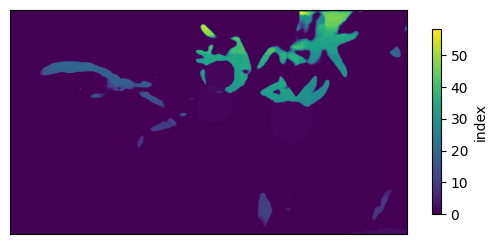

In [16]:
plt.imshow(np.sum(results[-1][0].masks.data.numpy(),0))
plt.xticks([]),plt.yticks([])
plt.colorbar(shrink=0.5,label="index")
plt.show()

### Refining segmentation masks / Retrieve tomatoes 

In [17]:
print("segmentation groups:        ",results[-1][0].names)
print("segmentation index per mask:",results[-1][0].boxes.cls.numpy().astype(int))

segmentation groups:         {0: 'tomato', 1: 'stam'}
segmentation index per mask: [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]


In [18]:
def get_first_label(mask):
    binmask = mask.masks.data.numpy()
    labels  = measure.label(binmask, background=0)
    return labels==1

binary_masks = [i[0].masks.data.numpy() for i in results]
CLS          = [i[0].boxes.cls.numpy() for i in results]
seg_inds     = [np.where(i == 0) for i in CLS]
seg_masks    = [binary_masks[i][seg_inds[i]]for i in range(len(CLS))]

In [19]:
def labels_2D(mask):
    labels = np.zeros_like(mask[0])
    for n,i in enumerate(mask):
        labels[i==1] = n+1
    return labels.astype("int")

segments = np.stack([labels_2D(i) for i in seg_masks])
mediapy.show_video(segments[:,::2,::2].astype("uint8")*100,fps=10)

In the annimation above we can see that the tomato indices are not synchronized and that there are many false positives.

## Tracking
We will try to track the individual tomatoes beased on their centroids using a costume Nearest Neighbor (NN) tracking approach 

### Centroid estimation

In [20]:
def get_simple_centroids(labels):
    centers = []
    for i in labels: ### loop over all labels
        reg = measure.regionprops(i)
        c_per_frame = []
        for j in reg: ### loop over all regions
            c_per_frame.append(j.centroid)
        centers.append(np.stack(c_per_frame))
    return centers

centers = get_simple_centroids(segments) ### retrieve centroids for each label

### Nearest Neighbor association 
We produce a cascade of connected NN to eliminate outliers. 

In [ ]:
def get_NN(point,next_frame,radius=30):
    TREE     = spatial.KDTree(next_frame)
    _,IND    = TREE.query(point,distance_upper_bound=radius)
    if IND == len(next_frame):
        return None
    else:
        return list(next_frame[IND])

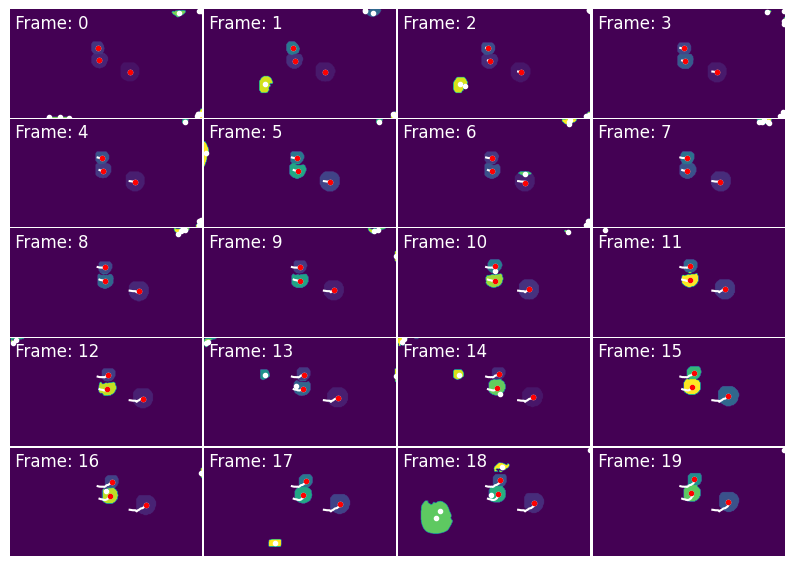

In [21]:
def get_NN_in_next(this_frame,next_frame,radius=3):
    new_points = []
    for i in this_frame:
        pp = get_NN(i[-2:],next_frame,radius=radius)
        if pp == None:
            pass
        else:
            new_points.append(list(i)+pp)
    return new_points

def NN_cascade(point_set,radius=30):

    PSA  = []
    PSC  = np.vstack([np.arange(len(point_set[0])),point_set[0].T]).T
    PSA.append(PSC)
    for i in range(1,len(point_set)):
        PSC  = get_NN_in_next(PSC,point_set[i],radius=radius)
        PSA.append(PSC)
    return np.asarray(PSC),PSA

PSB,PSA = NN_cascade(centers,radius=20)
PSC     = np.stack(PSA[-1])
ID      = PSC[:,0]
Y       = PSC[:,1::2]
X       = PSC[:,2::2]

plt.figure(figsize=(10,7.1))
for i in range(len(segments)):
    plt.subplot(5,4,i+1)
    plt.imshow(segments[i])
    plt.plot(centers[i][:,1],centers[i][:,0], ".w")
    for j in range(len(X)):
        plt.plot(X[j,:i],Y[j,:i], "-w")
    plt.plot(X[:,i],Y[:,i], ".r")
    plt.axis("off")
    plt.title(" Frame: "+str(i),loc="left",y=0.75,color="w")
plt.subplots_adjust(wspace=0.01,hspace=0.01)
plt.show()

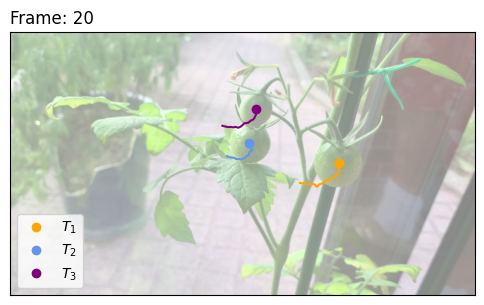

In [22]:
def plot_labels(images, labels, X, Y, f=20):
    plt.figure(figsize=(6,3.5))
    plt.imshow(cv2.resize(images[f-1],(labels[-1].shape[::-1])),alpha=0.5)
    plt.title("Frame: "+str(f), loc = "left")
    cols = ["orange","cornflowerblue","purple"]
    #plt.plot(centers[-1][:,1],centers[-1][:,0], "xk",markersize=4,label="fp")
    for j in range(len(X)):
        plt.plot(X[j,:],Y[j,:]  , "-", color=cols[j])
        plt.plot(X[j,-1],Y[j,-1], "o", color=cols[j],label=r"$T_"+str(j+1)+r"$")

    plt.yticks([]),plt.xticks([])
    plt.legend(loc="lower left")
    #plt.savefig("tracking.pdf",transparent=True,bbox_inches="tight",dpi=200)
    plt.show()
    
plot_labels(images, segments, X, Y)

### Associate instances with centroids 

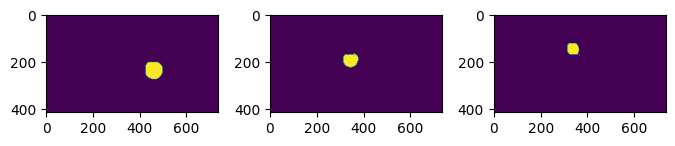

In [23]:
def associate_cells(labels,X,Y):
    tracks = []
    for i in range(len(labels)):
        annos = []
        for n in range(len(X)):
            #print(int(Y[i][n]),int(X[i][n]))
            label = labels[i][int(Y.T[i][n]),int(X.T[i][n])]
            new   = labels[i]==label
            annos.append(new)
        tracks.append(annos)
    return np.stack(tracks)

tomatoes = associate_cells(segments,X,Y)

plt.figure(figsize=(8,3))
for n,i in enumerate(tomatoes[0]):
    plt.subplot(1,3,n+1)
    plt.imshow(i)
plt.subplots_adjust(wspace=0.3)
plt.show()

### Plot the results

In [24]:
def resize_mask(mask,image):
    new_mask = transform.resize(mask,
                                image.shape[:2],
                                order=0,
                                preserve_range=False,
                                anti_aliasing=True)
    return  new_mask

def plot_track(images, bin_tracks, IND=0):
    cols = ["orange","cornflowerblue","purple"]
    cmp  = LinearSegmentedColormap.from_list('testCmap', 
                                             colors=cols, 
                                             N=bin_tracks[IND].shape[0])
    
    fig = plt.figure(figsize=(12,6.8),
                     frameon=True,
                     layout="constrained",
                     dpi=100) 
    
    plt.imshow(images[IND])
    for n,i in enumerate(bin_tracks[IND].astype(int)):
        plt.contour(resize_mask(i,
                                images[IND])*(n+1)*len(bin_tracks[IND]),
                    linewidths = 4,
                    colors     = np.asarray(cmp(n)).reshape(-1,4))
    plt.axis("off")
    im = fig_to_np(fig)
    plt.close()
    return im


tomato_detections = np.stack([plot_track(images, tomatoes,i) for i in tqdm(range(len(images)))])
mediapy.show_video(tomato_detections[:,::2,::2],fps=10)
mediapy.write_video("tracking.mp4",tomato_detections,fps=10)

100%|███████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.39it/s]
